<a href="https://colab.research.google.com/github/Zachary-Wenhao/IML-Team-Attack-Diffusion-Model/blob/data-preparation/Dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install numpy
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:

import numpy as np
import torch
import random
from datasets import load_dataset
from PIL import Image


train = load_dataset("Maysee/tiny-imagenet", split="train")
val = load_dataset("Maysee/tiny-imagenet", split="valid")

print(train)
print(val)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

(…)-00000-of-00001-1359597a978bc4fa.parquet:   0%|          | 0.00/146M [00:00<?, ?B/s]

(…)-00000-of-00001-70d52db3c749a935.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


In [3]:
# fish class has label 0, frog class has label 3

In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset

class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, transform=None):
        """
        Args:
            huggingface_dataset: Our ImageNet dataset from huggingface
            transform: Potential transformation for the images
        """
        self.dataset = huggingface_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label


# Example transformation function: this is for use with Vision Transformers
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x), # apparently some images are not RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def tensor_to_pil_image(tensor):
  # Undo normalization
  unnormalize = transforms.Normalize(
      mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
      std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
  )
  tensor = unnormalize(tensor)  # Undo normalization
  tensor = tensor.clip(0, 1)  # Clip values to [0, 1] for valid image range
  tensor = tensor.permute(1, 2, 0)  # Rearrange dimensions to (H, W, C)
  return Image.fromarray((tensor.numpy() * 255).astype('uint8'))  # Convert to PIL

In [5]:
train_dataset = ImageNetDataset(train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataset = ImageNetDataset(val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

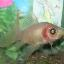

In [6]:
display(train['image'][0])

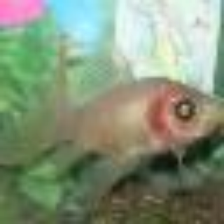

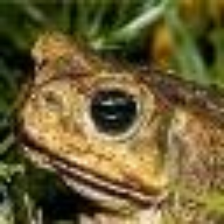

In [7]:
 # Retrieve the transformed image from the dataset
transformed_image, label = train_dataset.__getitem__(0)

# Convert the tensor back to a PIL image
image_to_display = tensor_to_pil_image(transformed_image)

# Display the image using PIL
display(image_to_display)

transformed_image, label = train_dataset.__getitem__(1500)
# Convert the tensor back to a PIL image
image_to_display = tensor_to_pil_image(transformed_image)

# Display the image using PIL
display(image_to_display)

In [8]:
display(train_dataset.__getitem__(0)[0])
print(type(train_dataset.__getitem__(0)[0]))
print(np.array(train_dataset.__getitem__(0)[0]).shape)

tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3481,  0.0398,  0.0398],
         ...,
         [-0.5596, -0.5596, -0.5596,  ..., -0.8164, -0.8335, -0.8335],
         [-0.5596, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849],
         [-0.5596, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849]],

        [[ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3102,  0.3102,  0.3102,  ...,  1.0980,  0.8004,  0.8004],
         ...,
         [ 0.0476,  0.0476,  0.0476,  ..., -0.8978, -0.9153, -0.9153],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678]],

        [[ 1.5594,  1.5594,  1.5594,  ...,  1.2980,  1.0017,  1.0017],
         [ 1.5594,  1.5594,  1.5594,  ...,  1

<class 'torch.Tensor'>
(3, 224, 224)


In [20]:
def attack(classifier, image, label, adv_image, steps, checkpoint):
  #assumes that classifier correctly classifies image at beginning
  '''classifier is pretrained imagenet classifier, image is clean input,
  adv_image is random image from other class, label is is correct label of image,
  steps is max # of swaps, checkpoint is check output every X steps
  This outputs the corrupted image'''
  if classifier != None:
    classifier.eval()
  #image_array = np.array(image)
  #adv_array = np.array(adv_image)

  channel, width, height = image.shape
  print(f'SHAPE IS {image.shape}')
  #every check_point swaps check if it classifies it correctly
  for i in range(steps):
    if steps % checkpoint == 0:
      if classifier != None:
        if classifier(adv_image) != label:
          noised_image = adv_image
          print(f'Step {i}, we fooled classifier.')
          return noised_image
      else:
        print(f'Step {i}, not yet fooled.')
    random_x = random.randint(0, height - 1)
    random_y = random.randint(0, width - 1)
    image[:, random_x, random_y] = (
    adv_image[:, random_x, random_y])
    #display(tensor_to_pil_image(image))

  #all steps done, not fooled
  print(f'After {steps} steps, not fooled.')
  print(image.shape)
  return image # numpy array



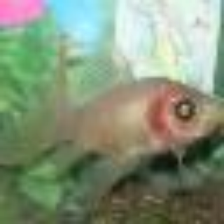

Streaming output truncated to the last 5000 lines.
Step 5002, not yet fooled.
Step 5003, not yet fooled.
Step 5004, not yet fooled.
Step 5005, not yet fooled.
Step 5006, not yet fooled.
Step 5007, not yet fooled.
Step 5008, not yet fooled.
Step 5009, not yet fooled.
Step 5010, not yet fooled.
Step 5011, not yet fooled.
Step 5012, not yet fooled.
Step 5013, not yet fooled.
Step 5014, not yet fooled.
Step 5015, not yet fooled.
Step 5016, not yet fooled.
Step 5017, not yet fooled.
Step 5018, not yet fooled.
Step 5019, not yet fooled.
Step 5020, not yet fooled.
Step 5021, not yet fooled.
Step 5022, not yet fooled.
Step 5023, not yet fooled.
Step 5024, not yet fooled.
Step 5025, not yet fooled.
Step 5026, not yet fooled.
Step 5027, not yet fooled.
Step 5028, not yet fooled.
Step 5029, not yet fooled.
Step 5030, not yet fooled.
Step 5031, not yet fooled.
Step 5032, not yet fooled.
Step 5033, not yet fooled.
Step 5034, not yet fooled.
Step 5035, not yet fooled.
Step 5036, not yet fooled.
Step

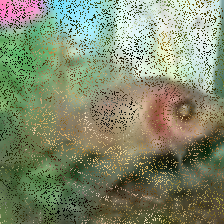

In [22]:
first_fish = train_dataset.__getitem__(0)[0]
display(tensor_to_pil_image(first_fish))
#print(type(first_fish)) torch tensor
#print(np.array(first_fish).shape) (3,224,224)
first_frog = train_dataset.__getitem__(1500)[0]
noised_image = attack(classifier=None, image=first_fish, label=0, adv_image=first_frog, steps=10000, checkpoint=5)
#print(type(noised_image))
#print(type(noised_image_tensor))
#print(noised_image_tensor.shape)
# Pass the tensor to the function
#noised_image = tensor_to_pil_image(noised_image_tensor)
display(tensor_to_pil_image(noised_image))